## Train an UnSupervised RandomCutForest model using the data stored in feature store

In [2]:
import boto3
import sagemaker
from sagemaker.session import Session


region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

In [3]:
from sagemaker.feature_store.feature_group import FeatureGroup

fd_feature_group_name = 'transactionfeaturegroup001'

fd_feature_group = FeatureGroup(name=fd_feature_group_name, sagemaker_session=feature_store_session)

## Build Training Dataset

SageMaker FeatureStore automatically builds the Glue Data Catalog for FeatureGroups (you can optionally turn it on/off while creating the FeatureGroup). In this example, we want to create one training dataset with FeatureValues from both identity and transaction FeatureGroups. This is done by utilizing the auto-built Catalog. We run an Athena query that joins the data stored in the offline store in S3 from the 2 FeatureGroups. 

In [4]:
# You can modify the following to use a bucket of your choosing
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-demo'

print(default_s3_bucket_name)

sagemaker-us-east-1-365792799466


In [5]:
transaction_query = fd_feature_group.athena_query()

transaction_table = transaction_query.table_name

print(transaction_table)

query_string = 'SELECT * FROM "'+transaction_table+'"'
print('Running ' + query_string)

# run Athena query. The output is loaded to a Pandas dataframe.
#dataset = pd.DataFrame()
transaction_query.run(query_string=query_string, output_location='s3://'+default_s3_bucket_name+'/'+prefix+'/query_results/')
transaction_query.wait()
dataset = transaction_query.as_dataframe()

dataset

transactionfeaturegroup001-1629730459
Running SELECT * FROM "transactionfeaturegroup001-1629730459"


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v26,v27,v28,amount,class,event_time,record_id,write_time,api_invocation_time,is_deleted
0,71503.0,-1.406379,1.193442,0.932727,-1.217894,-0.552076,-1.128438,0.204981,0.143193,0.163657,...,0.659737,-0.647898,0.073977,7.68,0.0,1.629730e+09,109710,2021-08-23 15:02:54.795,2021-08-23 14:57:30.000,False
1,37.0,1.295668,0.341483,0.081505,0.566746,-0.110459,-0.766325,0.073155,-0.168304,0.071837,...,0.127881,-0.023731,0.025200,0.99,0.0,1.629730e+09,55,2021-08-23 15:02:54.795,2021-08-23 14:57:30.000,False
2,71525.0,1.291485,-1.095189,-0.301904,-2.623376,-1.312201,-1.456160,-0.262129,-0.238359,0.640486,...,-0.689670,0.050912,0.014404,63.54,0.0,1.629730e+09,109752,2021-08-23 15:02:54.795,2021-08-23 14:57:30.000,False
3,98.0,1.027114,-1.272543,0.673656,-0.747436,-1.299107,0.293656,-1.054200,0.234900,-0.574991,...,-0.030996,0.018465,0.033482,159.00,0.0,1.629730e+09,158,2021-08-23 15:02:54.795,2021-08-23 14:57:32.000,False
4,71580.0,1.244781,0.115431,0.111972,0.388976,0.083840,-0.040992,-0.023859,-0.007790,0.122738,...,0.175155,-0.017849,0.009555,17.99,0.0,1.629730e+09,109878,2021-08-23 15:02:54.795,2021-08-23 14:57:32.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164529,71455.0,1.232264,0.185778,-0.029376,0.674766,0.407076,0.562455,-0.123681,0.194493,-0.073745,...,-0.352931,0.031514,-0.000818,2.50,0.0,1.629730e+09,109609,2021-08-23 15:12:22.929,2021-08-23 15:09:54.000,False
164530,71461.0,1.271109,-0.860215,-0.167019,-0.844150,-0.502688,0.068691,-0.484409,-0.008597,-0.797508,...,-0.208296,-0.016545,0.006612,100.00,0.0,1.629730e+09,109620,2021-08-23 15:12:22.929,2021-08-23 15:09:54.000,False
164531,116747.0,2.053118,0.133098,-1.765097,0.566274,0.047303,-1.580677,0.187834,-0.319220,0.795872,...,-0.099420,-0.010316,-0.031565,4.35,0.0,1.629730e+09,164481,2021-08-23 15:12:22.929,2021-08-23 15:09:54.000,False
164532,116770.0,1.889157,-0.500800,-2.138707,0.539548,2.276821,4.078737,-0.640655,0.992330,0.967167,...,-0.801186,0.052966,-0.045232,34.40,0.0,1.629730e+09,164507,2021-08-23 15:12:22.929,2021-08-23 15:09:55.000,False


In [6]:
# Select useful columns for training with target column as the first.
dataset = dataset[['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class']]


In [16]:
dataset = dataset.dropna()

The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulant with only $492$ ($.173\%$) of the data corresponding to fraudulant examples.

In [17]:
nonfrauds, frauds = dataset.groupby('class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  358
Number of non-frauds:  164175
Percentage of fradulent data: 0.21758552995447722


This dataset has 28 columns, $V_i$ for $i=1..28$ of anonymized features along with columns for time, amount, and class. We already know that the columns $V_i$ have been normalized to have $0$ mean and unit standard deviation as the result of a PCA. You can read more about PCA here:. 

Tip: For our dataset this amount of preprocessing will give us reasonable accuracy, but it's important to note that there are more preprocessing steps one can use to improve accuracy . For unbalanced data sets like ours where the positive (fraudulent) examples occur much less frequently than the negative (legitimate) examples, we may try “over-sampling” the minority dataset by generating synthetic data (read about SMOTE in Data Mining for Imbalanced Datasets: An Overview (https://link.springer.com/chapter/10.1007%2F0-387-25465-X_40) or undersampling the majority class by using ensemble methods (see http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.6858&rep=rep1&type=pdfor).

In [18]:
feature_columns = dataset.columns[:-1]
label_column = dataset.columns[-1]

features = dataset[feature_columns].values.astype('float32')
labels = (dataset[label_column].values).astype('float32')

Let's do some analysis and discuss different ways we can preprocess our data. Let's discuss the way in which this data was preprocessed.

## Amazon SageMaker RandomCutForest

In a fraud detection scenario, commonly we will have very few labeled examples, and it's possible that labeling fraud takes a very long time. We would like then to extract information from the unlabeled data we have at hand as well. _Anomaly detection_ is a form of unsupervised learning where we try to identify anomalous examples based solely on their feature characteristics. Random Cut Forest is a state-of-the-art anomaly detection algorithm that is both accurate and scalable. We will train such a model on our training data and evaluate its performance on our test set.

We will split our dataset into a train and test to evaluate the performance of our models. It's important to do so _before_ any techniques meant to alleviate the class imbalance are used. This ensures that we don't leak information from the test set into the train set.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42)


---
## Train


In [21]:
import os
import sagemaker

session = sagemaker.Session()
bucket = default_s3_bucket_name
prefix = 'rcf-fraud-classifier'

In [22]:
sagemaker_iam_role = sagemaker.get_execution_role()

In [23]:
from sagemaker import RandomCutForest

# specify general training job information
rcf = RandomCutForest(role=sagemaker_iam_role,
                      instance_count=1,
                      instance_type="ml.m5.xlarge",
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      base_job_name="{}-rcf".format("fraud-detection"),
                      num_samples_per_tree=512,
                      num_trees=50)

In [24]:
rcf.fit(rcf.record_set(X_train))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-08-23 17:12:35 Starting - Starting the training job...
2021-08-23 17:13:02 Starting - Launching requested ML instancesProfilerReport-1629738755: InProgress
......
2021-08-23 17:14:02 Starting - Preparing the instances for training.........
2021-08-23 17:15:22 Downloading - Downloading input data...
2021-08-23 17:16:03 Training - Training image download completed. Training in progress.
2021-08-23 17:16:03 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[08/23/2021 17:15:57 INFO 140577644418880] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metri

### Host RCF Model


Once we have a trained model we can deploy it and get some predictions for our test set. SageMaker will spin up an instance for us and deploy the model, the whole process should take around 10 minutes, you will see progress being made with each `-` and an exclamation point when the process is finished.

In [25]:
rcf_predictor = rcf.deploy(
    model_name="{}-rcf".format("fraud-detection"),
    endpoint_name="{}-rcf".format("fraud-detection"),
    initial_instance_count=1,
    instance_type="ml.c5.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


------------------!

In [28]:
from sagemaker.predictor import CSVSerializer,JSONDeserializer

rcf_predictor.serializer = CSVSerializer()
rcf_predictor.deserializer = JSONDeserializer()

### Test Random Cut Forest

With the model deployed, let's see how it performs in terms of separating fraudulent from legitimate transactions.

In [29]:
def predict_rcf(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        array_preds = [s['score'] for s in current_predictor.predict(array)['scores']]
        predictions.append(array_preds)

    return np.concatenate([np.array(batch) for batch in predictions])

In [31]:
import numpy as np

positives = X_test[y_test == 1]
positives_scores = predict_rcf(rcf_predictor, positives)

negatives = X_test[y_test == 0]
negatives_scores = predict_rcf(rcf_predictor, negatives)

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

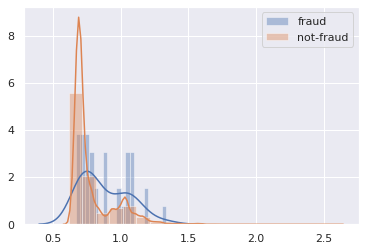

In [33]:
sns.distplot(positives_scores, label='fraud', bins=20)
sns.distplot(negatives_scores, label='not-fraud', bins=20)
plt.legend()

The unsupervised model already can achieve some separation between the classes, with higher anomaly scores being correlated to fraud.